# The Friendship Paradox

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2)

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import random
import networkx as nx
import numpy as np

import thinkplot
from thinkstats2 import Pmf, Cdf

## BA graphs

In "[Why Your Friends Have More Friends than You Do](https://github.com/AllenDowney/ThinkComplexity2/blob/master/papers/feld1991why.pdf)", Scott L. Feld explains the "friendship paradox": if you choose one of your friends at random, the chances are high that your friend has more friends than you.

In this notebook, we'll explore this effect in a random Barabasi-Albert graph and in a small dataset from Facebook.

First, I'll generate a BA graph:

In [2]:
G = nx.barabasi_albert_graph(n=4000, m=20)

The following generator iterates through the nodes of a graph.  We could also use `G.node_iter`, but I am setting up the framework we'll use later in the notebook.

In [3]:
def generate_nodes(G):
    for node in G:
        yield node

This function generates a sample of nodes.

In [4]:
def sample_nodes(G, n=1000):
    nodes = G.nodes()
    for i in range(n):
        node = np.random.choice(nodes)
        yield node

Now let's confirm that `sample_nodes` generates the right degree distribution.

In [5]:
def compare_node_degree(G):
    # enumerate all the nodes
    node_degree = [G.degree(node) for node in generate_nodes(G)]
    thinkplot.Cdf(Cdf(node_degree), label='generate_nodes')

    # generate a random sample of nodes
    node_degree_sample = [G.degree(node) for node in sample_nodes(G)]
    thinkplot.Cdf(Cdf(node_degree_sample), label='sample_nodes')
    
    thinkplot.Config(xlabel='degree', ylabel='CDF')

It does.

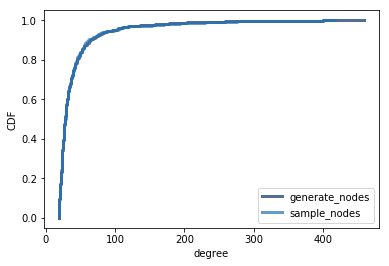

In [6]:
compare_node_degree(G)

## Sampling friends

Now let's generate all the "friends" by iterating through the nodes and their friends:

In [7]:
def generate_friends(G):
    for node in G:
        for friend in G[node]:
            yield friend

And let's sample friends by choosing a random node and then a random friend.

In [8]:
def sample_friends(G, n=1000):
    nodes = G.nodes()
    for _ in range(n):
        node = np.random.choice(nodes)
        friends = G.neighbors(node)
        friend = np.random.choice(friends)
        yield friend

In Feld's article, he does something a little different: he chooses a random edge and then chooses one of the endpoints:

In [9]:
def sample_edges(G, n=1000):
    edges = G.edges()
    for _ in range(n):
        # NOTE: you can't use np.random.choice to choose
        # from edges, because it treats a list of pairs
        # as an array with two columns
        edge = random.choice(edges)
        yield random.choice(edge)

Let's see if all of these generators produce the same distribution:

In [10]:
def compare_friend_degree(G):
    
    # enumerate the nodes
    node_degree = [G.degree(node) for node in generate_nodes(G)]
    thinkplot.Cdf(Cdf(node_degree), color='gray')
    
    # enumerate the friends
    friend_degree = [G.degree(node) for node in generate_friends(G)]
    thinkplot.Cdf(Cdf(friend_degree), label='generate_friends')

    # sample friends
    friend_degree_sample = [G.degree(node) for node in sample_friends(G)]
    thinkplot.Cdf(Cdf(friend_degree_sample), color='green', label='sample_friends')
    
    # sample edges
    edge_degree_sample = [G.degree(node) for node in sample_edges(G)]
    thinkplot.Cdf(Cdf(edge_degree_sample), color='red', label='sample_edges')
    
    thinkplot.Config(xlabel='degree', ylabel='CDF')

It looks like they do, at least approximately.

And, as expected, the distribution we get when we sample friends (either way) is different from what we get when we sample nodes.

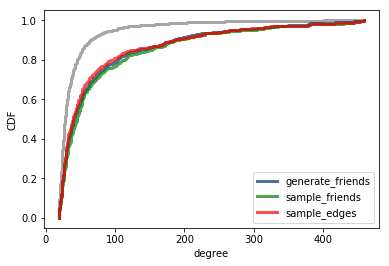

In [11]:
compare_friend_degree(G)

## Facebook data

Now let's run the same analysis on the Facebook dataset.

In [12]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

In [13]:
# https://snap.stanford.edu/data/facebook_combined.txt.gz

fb = read_graph('facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m, m/n

(4039, 88234, 21.846)

Once again, the degree distribution is the same whether we enumerate all nodes or sample them.

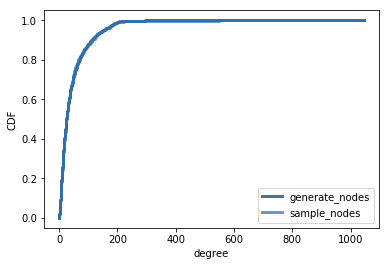

In [14]:
compare_node_degree(fb)

But now we get something I didn't expect.  We get two different degree distributions for "friends":

1) If we sample edges, as Feld did, or if we enumerate all friends, we get one distribution.

2) If we sample by choosing a node and then a friend, we get another distribition.


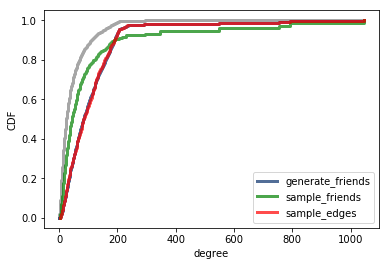

In [15]:
compare_friend_degree(fb)

## Analysis

We can compute the distribution of degree by modeling the edge sampling process.

In [16]:
def edge_degree_cdf(G):
    pmf = Pmf()
    for u, v in G.edges():
        pmf[G.degree(u)] += 1
        pmf[G.degree(v)] += 1
    pmf.Normalize()
    return pmf.MakeCdf()

And confirm that the sample matches the computed distribution.

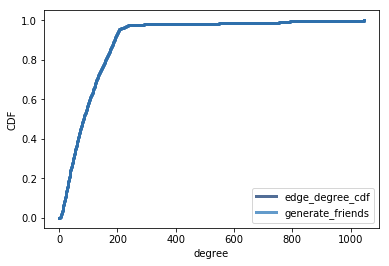

In [17]:
cdf = edge_degree_cdf(fb)
thinkplot.Cdf(cdf, label='edge_degree_cdf')

friend_degree = [fb.degree(node) for node in generate_friends(fb)]
thinkplot.Cdf(Cdf(friend_degree), label='generate_friends')

thinkplot.Config(xlabel='degree', ylabel='CDF')

We can also think of this distribution as a biased view of the degree distribution, where each node is overrepresented proportional to its degree.

In [18]:
def edge_degree_cdf2(G):
    degrees = [G.degree(node) for node in G]
    pmf = Pmf(degrees)
    for x, p in pmf.Items():
        pmf[x] *= x
    pmf.Normalize()
    return pmf.MakeCdf()

And again, that agrees with the sample.

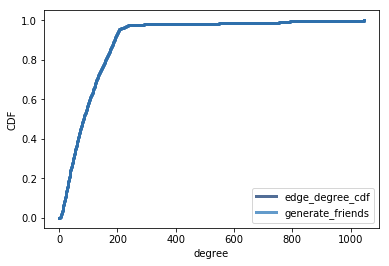

In [19]:
cdf = edge_degree_cdf2(fb)
thinkplot.Cdf(cdf, label='edge_degree_cdf')

friend_degree = [fb.degree(node) for node in generate_friends(fb)]
thinkplot.Cdf(Cdf(friend_degree), label='generate_friends')

thinkplot.Config(xlabel='degree', ylabel='CDF')

We can also compute the distribution that results from the friend sampling process.

In [20]:
def friend_degree_cdf(G):
    n = len(G)
    pmf = Pmf()
    for node in G:
        friends = G[node]
        f = len(friends)
        for friend in friends:
            degree = G.degree(friend)
            pmf[degree] += 1 / n / f
    pmf.Normalize()
    return pmf.MakeCdf()

And confirm that it agrees with the friend sample.

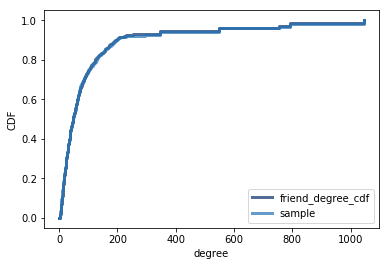

In [21]:
cdf = friend_degree_cdf(fb)
thinkplot.Cdf(cdf, label='friend_degree_cdf')

friend_degree_sample = [fb.degree(node) for node in sample_friends(fb)]
thinkplot.Cdf(Cdf(friend_degree_sample), label='sample')

thinkplot.Config(xlabel='degree', ylabel='CDF')

So it looks like we have two interpretations of the friendship paradox, which are operationalized by two different sampling processes.

Also, the sampling processes yield the same degree distribution for some graphs, like the BA model, but not for others, like the Facebook dataset.

Questions this raises:

1. Which process better quantifies the friendship paradox?  Are there other metrics we should compute, other than degree distributions?

2. Why are the results different for these two graphs?

3. How do the results differ for other graphs?

4. Are there metrics we can compute directly based on graph properties, rather than by sampling?

## Degree correlation

One property that might vary from graph to graph, and affect our results, is the correlation between the degrees of adjacent nodes.

Here's how we can compute it:


In [22]:
def get_degree_pairs(G):
    res = []
    for u, v in G.edges_iter():
        res.append((G.degree(u), G.degree(v)))
    return np.array(res).transpose()

The BA graph has relatively high correlation.

In [23]:
degree_pairs = get_degree_pairs(G)
np.corrcoef(degree_pairs)

array([[ 1.   ,  0.348],
       [ 0.348,  1.   ]])

The Facebook network has lower correlation.

In [24]:
degree_pairs = get_degree_pairs(fb)
np.corrcoef(degree_pairs)

array([[ 1.   ,  0.125],
       [ 0.125,  1.   ]])

## Friends of friends

Another exploration that might be interesting: how does all of this affect the disrtribution for friends of friends?

In [25]:
def sample_fof_degree(G):
    nodes = G.nodes()
    node = np.random.choice(nodes)
    friends = G.neighbors(node)
    friend = np.random.choice(friends)
    fofs = G.neighbors(friend)
    fof = np.random.choice(fofs)
    return G.degree(fof)

In [26]:
sample_fof_degree(fb)

21

In [27]:
fof_sample = [sample_fof_degree(fb) for _ in range(10000)]
fof_cdf = Cdf(fof_sample)

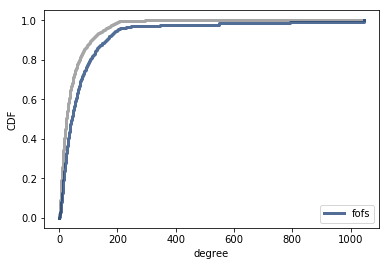

In [30]:
node_degree = [fb.degree(node) for node in generate_nodes(fb)]
thinkplot.Cdf(Cdf(node_degree), color='gray')

thinkplot.Cdf(fof_cdf, label='fofs')
thinkplot.Config(xlabel='degree', ylabel='CDF')